This note book contains the implementation of 2 different models which are used to perform image recognistion on a subset dataset of CIFAR-10 dataset.
The first half is going to be the development of a neural network. In the later half will be then, a  convolutional neural network

In [440]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.feature
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix
import itertools

Loading in the data and doing some check on shape and boundaries

In [441]:
train_images = np.load('trnImage.npy')
train_labels = np.load('trnLabel.npy')
test_images = np.load('tstImage.npy')
test_labels = np.load('tstLabel.npy')
labels = ['airplanes','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

print('image shape: ' ,train_images.shape)
print('label shape: ' ,train_labels.shape)

print("max: ",train_images.max())
print("min: ",train_images.min())

image shape:  (32, 32, 3, 10000)
label shape:  (10000, 1)
max:  1.0
min:  0.0


Data was scaled already but need to change the shape of the images and labels

In [442]:
train_labels = train_labels.reshape(-1)
test_labels = test_labels.reshape(-1)

train_images = np.transpose(train_images,[3,0,1,2])
test_images = np.transpose(test_images,[3,0,1,2])

print('image shape: ' ,train_images.shape)
print('label shape: ' ,train_labels.shape)

image shape:  (10000, 32, 32, 3)
label shape:  (10000,)


This chunk of code is to get the output size of each hog

In [537]:
train_hog = skimage.feature.hog(image,block_norm = "L2-Hys", visualize=False)
print(f'The extracted feature vector is of length {train_hog.shape[0]} per sample')

The extracted feature vector is of length 324 per sample


Anything before this was mutual for both models but from now on these are specifics for nn.
I extract the value for histogram of oriented gradients of each each image and add it to a new list which will be used.

In [443]:
train_hog  = np.zeros((train_images.shape[0],324))
test_hog = np.zeros((test_images.shape[0], 324))
for i in range(train_images.shape[0]):
    image = train_images[i, :,: ,:]
    train_hog[i] = skimage.feature.hog(image,block_norm = "L2-Hys", visualize=False)
for i in range(test_images.shape[0]):
    image = test_images[i, :,: ,:]
    test_hog[i] = skimage.feature.hog(image,block_norm = "L2-Hys", visualize=False)
    
print(train_hog.shape)

(10000, 324)


As you can see, the labels file has a step behaviour which is not ideal for trainng

<function matplotlib.pyplot.show(close=None, block=None)>

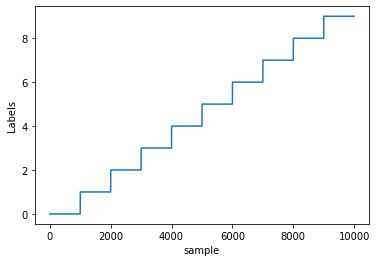

In [444]:
plt.figure()
plt.plot(train_labels)
plt.xlabel('sample')
plt.ylabel('Labels')
plt.show

So to solve this I'm goin to use an special imported function that shuffles our dataset. (I've given random_state a set value in order to compare different attribute changes )

In [445]:
x_train, x_test, y_train, y_test = train_test_split(train_hog, train_labels, test_size=0.2 , random_state = 42)

print(x_train.shape)
print(test_images.shape)

(8000, 324)
(1000, 32, 32, 3)


Using PCA to reduce the dimentionality to take the attributes that are included in 90% of the variance

In [446]:
pca = PCA(0.9)
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)
nn_test_images = pca.transform(test_hog)

Feauture are reduces massively and is just 84 now

In [447]:
print('new shape: ', x_train.shape)

new shape:  (8000, 84)


Creating the model

In [451]:
nn_model = tf.keras.Sequential()
nn_model.add(tf.keras.layers.Dense(1024, activation=tf.nn.relu, input_shape=(x_train.shape[-1],)))
nn_model.add(tf.keras.layers.Dense(1024, activation=tf.nn.relu))
nn_model.add(tf.keras.layers.Dense(512, activation=tf.nn.relu))
nn_model.add(tf.keras.layers.Dense(256, activation=tf.nn.relu))
nn_model.add(tf.keras.layers.Dense(64, activation=tf.nn.relu))
nn_model.add(tf.keras.layers.Dense(len(np.unique(y_train)), activation=tf.nn.softmax))

In [452]:
model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_78 (Dense)             (None, 1024)              99328     
_________________________________________________________________
dense_79 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_80 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_81 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_82 (Dense)             (None, 10)                2570      
Total params: 1,807,626
Trainable params: 1,807,626
Non-trainable params: 0
_________________________________________________________________


Compiling the model and fitting it on our training dataset:

In [453]:
nn_model.compile(optimizer=tf.keras.optimizers.RMSprop(), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
              metrics=tf.keras.metrics.SparseCategoricalAccuracy())

history = nn_model.fit(x_train, y_train, epochs=100, validation_split=0.2, verbose=1)

Epoch 1/100
200/200 [==============================] - 5s 27ms/step - loss: 1.7406 - sparse_categorical_accuracy: 0.3675 - val_loss: 1.4772 - val_sparse_categorical_accuracy: 0.4650
Epoch 2/100
200/200 [==============================] - 5s 27ms/step - loss: 1.3433 - sparse_categorical_accuracy: 0.5269 - val_loss: 1.4131 - val_sparse_categorical_accuracy: 0.5181
Epoch 3/100
200/200 [==============================] - 5s 27ms/step - loss: 1.1002 - sparse_categorical_accuracy: 0.6169 - val_loss: 1.3955 - val_sparse_categorical_accuracy: 0.5256
Epoch 4/100
200/200 [==============================] - 5s 27ms/step - loss: 0.8532 - sparse_categorical_accuracy: 0.7020 - val_loss: 1.5132 - val_sparse_categorical_accuracy: 0.5250
Epoch 5/100
200/200 [==============================] - 5s 27ms/step - loss: 0.6198 - sparse_categorical_accuracy: 0.7823 - val_loss: 1.5519 - val_sparse_categorical_accuracy: 0.5350
Epoch 6/100
200/200 [==============================] - 5s 27ms/step - loss: 0.4305 - spars

Plotting the accuracy and loss curves(although they don't look the best!)

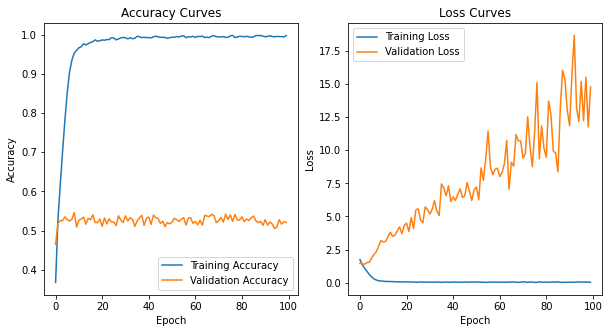

In [511]:
plt.figure(figsize=[10,5])
plt.subplot(121)
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.title('Accuracy Curves')

plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.title('Loss Curves')
plt.show()

Getting the precicios and recll value for each of the 10 categorie

In [456]:
nn_y_pred = nn_model.predict_classes(nn_test_images)
print(classification_report(test_labels, nn_y_pred, target_names = labels))

              precision    recall  f1-score   support

   airplanes       0.55      0.69      0.61       100
  automobile       0.65      0.56      0.60       100
        bird       0.49      0.42      0.45       100
         cat       0.36      0.33      0.34       100
        deer       0.45      0.53      0.49       100
         dog       0.44      0.54      0.48       100
        frog       0.68      0.60      0.64       100
       horse       0.66      0.55      0.60       100
        ship       0.56      0.57      0.57       100
       truck       0.65      0.64      0.64       100

    accuracy                           0.54      1000
   macro avg       0.55      0.54      0.54      1000
weighted avg       0.55      0.54      0.54      1000



Calculating the confusion matrix for the developed neural network model:

In [457]:
nn_Cmatrix = confusion_matrix(test_labels, nn_y_pred)

THIS FUNCTION WAS DIRECTLY COPIED FROM THE SICKIT-LEARN’S WEBSITE.

In [534]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Calling the implemented function to show the confusion matrics

Confusion matrix, without normalization


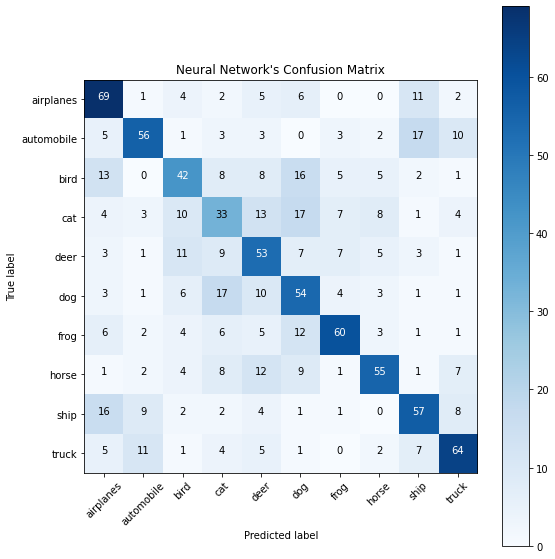

In [535]:
fig,ax = plt.subplots(figsize = (8,8))
plot_confusion_matrix(cm = nn_Cmatrix, classes = labels , title = "Neural Network's Confusion Matrix")

In [507]:
x_train, x_test, y_train, y_test = train_test_split(train_images, train_labels, test_size=0.2 , random_state = 42)

In [508]:
cnn_model = tf.keras.Sequential()
cnn_model.add(tf.keras.layers.Conv2D(32, (3, 3), padding='same',
                 input_shape=[32,32,3]))
cnn_model.add(tf.keras.layers.Activation('relu'))
cnn_model.add(tf.keras.layers.Conv2D(32, (3, 3)))
cnn_model.add(tf.keras.layers.Activation('relu'))
cnn_model.add(tf.keras.layers.MaxPooling2D((2, 2)))

cnn_model.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same'))
cnn_model.add(tf.keras.layers.Activation('relu'))
cnn_model.add(tf.keras.layers.Conv2D(64, (3, 3)))
cnn_model.add(tf.keras.layers.Activation('relu'))
cnn_model.add(tf.keras.layers.MaxPooling2D((2, 2)))

cnn_model.add(tf.keras.layers.Conv2D(128, (3, 3), padding='same'))
cnn_model.add(tf.keras.layers.Activation('relu'))
cnn_model.add(tf.keras.layers.Conv2D(128, (3, 3)))
cnn_model.add(tf.keras.layers.Activation('relu'))
cnn_model.add(tf.keras.layers.MaxPooling2D((2, 2)))

cnn_model.add(tf.keras.layers.Flatten())
cnn_model.add(tf.keras.layers.Dense((256)))
cnn_model.add(tf.keras.layers.Activation('relu'))
cnn_model.add(tf.keras.layers.Dense(len(np.unique(y_train))))
cnn_model.add(tf.keras.layers.Activation('softmax'))

In [509]:
cnn_model.summary()

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_46 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_38 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_39 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 15, 15, 64)        18496     
_________________________________________________________________
activation_40 (Activation)   (None, 15, 15, 64)      

In [510]:
cnn_model.compile(optimizer=tf.keras.optimizers.RMSprop(), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
              metrics=tf.keras.metrics.SparseCategoricalAccuracy())

cnn_history = cnn_model.fit(x_train, y_train, epochs=100, validation_split=0.2, verbose=1)

Epoch 1/100
200/200 [==============================] - 22s 108ms/step - loss: 2.1350 - sparse_categorical_accuracy: 0.2223 - val_loss: 1.7656 - val_sparse_categorical_accuracy: 0.3562
Epoch 2/100
200/200 [==============================] - 25s 125ms/step - loss: 1.8007 - sparse_categorical_accuracy: 0.3428 - val_loss: 1.5606 - val_sparse_categorical_accuracy: 0.4300
Epoch 3/100
200/200 [==============================] - 25s 124ms/step - loss: 1.6173 - sparse_categorical_accuracy: 0.4152 - val_loss: 1.6287 - val_sparse_categorical_accuracy: 0.4300
Epoch 4/100
200/200 [==============================] - 24s 122ms/step - loss: 1.4501 - sparse_categorical_accuracy: 0.4787 - val_loss: 1.4354 - val_sparse_categorical_accuracy: 0.4781
Epoch 5/100
200/200 [==============================] - 27s 133ms/step - loss: 1.2853 - sparse_categorical_accuracy: 0.5406 - val_loss: 1.2705 - val_sparse_categorical_accuracy: 0.5306
Epoch 6/100
200/200 [==============================] - 27s 134ms/step - loss: 1.

Getting the predicted labels in order to evalueate the model

In [523]:
cnn_y_pred = cnn_model.predict_classes(test_images)

In [524]:
cnn_Cmatrix = confusion_matrix(test_labels, cnn_y_pred)
print(classification_report(test_labels, cnn_y_pred, target_names = labels))

              precision    recall  f1-score   support

   airplanes       0.65      0.51      0.57       100
  automobile       0.64      0.74      0.69       100
        bird       0.39      0.49      0.44       100
         cat       0.41      0.39      0.40       100
        deer       0.50      0.54      0.52       100
         dog       0.47      0.52      0.50       100
        frog       0.65      0.70      0.67       100
       horse       0.74      0.50      0.60       100
        ship       0.74      0.77      0.75       100
       truck       0.69      0.61      0.65       100

    accuracy                           0.58      1000
   macro avg       0.59      0.58      0.58      1000
weighted avg       0.59      0.58      0.58      1000



Confusion matrix, without normalization
[[51  6 16  2  2  1  2  2 13  5]
 [ 1 74  1  3  0  2  1  0  6 12]
 [ 6  1 49 12  9 11  8  4  0  0]
 [ 3  3  9 39 12 24  9  1  0  0]
 [ 3  3 14  2 54  7  9  3  4  1]
 [ 0  0 14 12  9 52  7  5  0  1]
 [ 0  1  7 12  3  4 70  1  1  1]
 [ 1  1 10  7 17  9  1 50  0  4]
 [ 7  6  5  0  2  0  0  0 77  3]
 [ 7 20  0  5  1  0  1  2  3 61]]


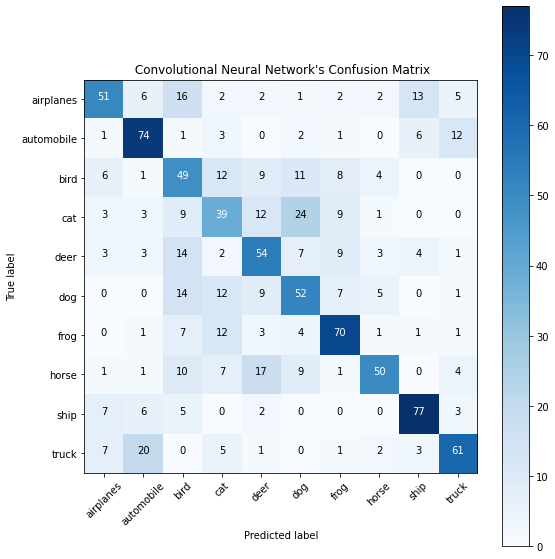

In [525]:
fig,ax = plt.subplots(figsize = (8,8))
plot_confusion_matrix(cm = cnn_Cmatrix, classes = labels , title = " Convolutional Neural Network's Confusion Matrix")

I evaluate the both models and compare the in a nice forat here

In [526]:
nn_results = nn_model.evaluate(nn_test_images, test_labels)
cnn_results = cnn_model.evaluate(test_images, test_labels)

32/32 [==============================] - 1s 40ms/step - loss: 12.9058 - sparse_categorical_accuracy: 0.5770


In [527]:
print(f' NN Test set loss: {nn_results[0]:0.2f}, NN test set accuracy: {nn_results[1]*100:0.2f}%')
print(f'CNN Test set loss: {cnn_results[0]:0.2f}, CNN test set accuracy: {cnn_results[1]*100:0.2f}%')

 NN Test set loss: 14.40, NN test set accuracy: 54.30%
CNN Test set loss: 12.91, CNN test set accuracy: 57.70%
